# Set-up & Configurations

In [8]:
# Run clone once per kernel session
if 'has_cloned' not in globals():
    has_cloned = False

In [9]:
# @title downloads trademaster-nyu
if not has_cloned:
    !git clone https://github.com/NeuralFlux/trademaster-nyu.git
    %cd trademaster-nyu
    has_cloned = True

In [10]:
# @title Install Packages
# %%capture
# !pip install setuptools==66
# !pip install dtaidistance
# !pip install fastdtw
# !pip install wheel==0.38.4
# !pip install -r requirements.txt
# !pip uninstall yapf -y
# !pip install yapf==0.40.1

# EIIE

In [1]:
# import dependencies
import os
import sys
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")
ROOT = os.path.dirname(os.path.abspath("."))
sys.path.append(ROOT)
import torch
import argparse
import os.path as osp
from mmcv import Config
from trademaster.utils import replace_cfg_vals
from trademaster.nets.builder import build_net
from trademaster.environments.builder import build_environment
from trademaster.datasets.builder import build_dataset
from trademaster.agents.builder import build_agent
from trademaster.optimizers.builder import build_optimizer
from trademaster.losses.builder import build_loss
from trademaster.trainers.builder import build_trainer
from trademaster.transition.builder import build_transition
from trademaster.utils import plot
from trademaster.utils import set_seed
set_seed(2023)

In [2]:
# settings initialization
parser = argparse.ArgumentParser(description='Download Alpaca Datasets')
parser.add_argument("--config", default=osp.join(ROOT, "trademaster-nyu", "configs", "portfolio_management", "portfolio_management_dj30_eiie_eiie_adam_mse.py"),
                    help="download datasets config file path")
parser.add_argument("--task_name", type=str, default="train")

args, _= parser.parse_known_args()
cfg = Config.fromfile(args.config)
task_name = args.task_name
cfg = replace_cfg_vals(cfg)

In [3]:
# default configurations
for key in cfg:
  print(f"{key}: {cfg[key]}")

data: {'type': 'PortfolioManagementDataset', 'data_path': 'data/portfolio_management/dj30', 'train_path': 'data/portfolio_management/dj30/train.csv', 'valid_path': 'data/portfolio_management/dj30/valid.csv', 'test_path': 'data/portfolio_management/dj30/test.csv', 'tech_indicator_list': ['zopen', 'zhigh', 'zlow', 'zadjcp', 'zclose', 'zd_5', 'zd_10', 'zd_15', 'zd_20', 'zd_25', 'zd_30'], 'length_day': 10, 'initial_amount': 100000, 'transaction_cost_pct': 0.001, 'test_dynamic_path': 'data/portfolio_management/dj30/test_with_label.csv'}
environment: {'type': 'PortfolioManagementEIIEEnvironment'}
agent: {'type': 'PortfolioManagementEIIE', 'memory_capacity': 1000, 'gamma': 0.99, 'policy_update_frequency': 500}
trainer: {'type': 'PortfolioManagementEIIETrainer', 'epochs': 2, 'work_dir': 'work_dir/portfolio_management_dj30_eiie_eiie_adam_mse', 'if_remove': False}
loss: {'type': 'MSELoss'}
optimizer: {'type': 'Adam', 'lr': 0.001}
act: {'type': 'EIIEConv', 'input_dim': None, 'output_dim': 1, 'tim

In [4]:
# you can view configuration settings in detail
cfg.data

{'type': 'PortfolioManagementDataset',
 'data_path': 'data/portfolio_management/dj30',
 'train_path': 'data/portfolio_management/dj30/train.csv',
 'valid_path': 'data/portfolio_management/dj30/valid.csv',
 'test_path': 'data/portfolio_management/dj30/test.csv',
 'tech_indicator_list': ['zopen',
  'zhigh',
  'zlow',
  'zadjcp',
  'zclose',
  'zd_5',
  'zd_10',
  'zd_15',
  'zd_20',
  'zd_25',
  'zd_30'],
 'length_day': 10,
 'initial_amount': 100000,
 'transaction_cost_pct': 0.001,
 'test_dynamic_path': 'data/portfolio_management/dj30/test_with_label.csv'}

In [5]:
# and make replacements as needed
cfg.data.data_path = 'data/portfolio_management/exchange'
cfg.data.train_path = 'data/portfolio_management/exchange/train.csv'
cfg.data.valid_path = 'data/portfolio_management/exchange/valid.csv'
cfg.data.test_path = 'data/portfolio_management/exchange/test.csv'
cfg.data.test_dynamic_path = 'data/portfolio_management/exchange/test_labeled_3_24_-0.05_0.05.csv'
cfg.data.transaction_cost_pct = 0.003
cfg.work_dir = 'work_dir/eiie_adam_mse_exchange'
cfg.data

{'type': 'PortfolioManagementDataset',
 'data_path': 'data/portfolio_management/exchange',
 'train_path': 'data/portfolio_management/exchange/train.csv',
 'valid_path': 'data/portfolio_management/exchange/valid.csv',
 'test_path': 'data/portfolio_management/exchange/test.csv',
 'tech_indicator_list': ['zopen',
  'zhigh',
  'zlow',
  'zadjcp',
  'zclose',
  'zd_5',
  'zd_10',
  'zd_15',
  'zd_20',
  'zd_25',
  'zd_30'],
 'length_day': 10,
 'initial_amount': 100000,
 'transaction_cost_pct': 0.003,
 'test_dynamic_path': 'data/portfolio_management/exchange/test_labeled_3_24_-0.05_0.05.csv'}

In [6]:
# building dataset
dataset = build_dataset(cfg)

In [7]:
train_environment = build_environment(cfg, default_args=dict(dataset=dataset, task="train"))
valid_environment = build_environment(cfg, default_args=dict(dataset=dataset, task="valid"))
test_environment = build_environment(cfg, default_args=dict(dataset=dataset, task="test"))
train_environment.df.head()

,date,close,tic,open,high,low,adjcp,zopen,zhigh,zlow,zadjcp,zclose,zd_5,zd_10,zd_15,zd_20,zd_25,zd_30
0,2000-01-04,0.656211,AUSTRALIAN DOLLAR,0.656211,0.656211,0.656211,0.656211,0.0,0.0,0.0,0.0,-0.004397,0.001568,-0.011881,0.008160,0.027933,0.028040,0.032544
0,2000-01-04,0.026932,BAHT,0.026932,0.026932,0.026932,0.026932,0.0,0.0,0.0,0.0,-0.004309,-0.007849,-0.014487,-0.017411,-0.019852,-0.022889,-0.024430
0,2000-01-04,0.688800,CANADIAN DOLLAR,0.688800,0.688800,0.688800,0.688800,0.0,0.0,0.0,0.0,-0.003651,-0.009164,-0.011967,-0.013248,-0.014619,-0.014858,-0.014843
0,2000-01-04,0.138543,DANISH KRONE,0.138543,0.138543,0.138543,0.138543,0.0,0.0,0.0,0.0,0.015378,-0.008646,-0.011328,-0.013422,-0.015202,-0.017156,-0.018115
0,2000-01-04,1.030928,EURO,1.030928,1.030928,1.030928,1.030928,0.0,0.0,0.0,0.0,0.015155,-0.005638,-0.007943,-0.008732,-0.009855,-0.011481,-0.012016


In [8]:
action_dim = train_environment.action_dim # 29
state_dim = train_environment.state_dim # 11
input_dim = len(train_environment.tech_indicator_list)
time_steps = train_environment.time_steps

cfg.act.update(dict(input_dim=input_dim, time_steps=time_steps))
cfg.cri.update(dict(input_dim=input_dim, action_dim= action_dim, time_steps=time_steps))

act = build_net(cfg.act)
cri = build_net(cfg.cri)
act_optimizer = build_optimizer(cfg, default_args=dict(params=act.parameters()))
cri_optimizer = build_optimizer(cfg, default_args=dict(params=cri.parameters()))

In [9]:
criterion = build_loss(cfg)

In [10]:
transition = build_transition(cfg)

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
agent = build_agent(cfg, default_args=dict(action_dim=action_dim,state_dim=state_dim,time_steps = time_steps,act=act,cri=cri,act_optimizer=act_optimizer,cri_optimizer = cri_optimizer,criterion=criterion,transition = transition,device = device))

In [12]:
trainer = build_trainer(cfg, default_args=dict(train_environment=train_environment,valid_environment=valid_environment,test_environment=test_environment,agent=agent,device=device))
work_dir = os.path.join(ROOT, "TradeMaster", cfg.trainer.work_dir)

if not os.path.exists(work_dir):
    os.makedirs(work_dir)
cfg.dump(osp.join(work_dir, osp.basename(args.config)))

Train Episode: [1/2]
+--------------+-------------+------------+--------------+
| Total Return | Sharp Ratio | Volatility | Max Drawdown |
+--------------+-------------+------------+--------------+
|  -7.130342%  |  -0.063537  | 0.327417%  |  24.900107%  |
+--------------+-------------+------------+--------------+
Valid Episode: [1/2]
+--------------+-------------+------------+--------------+
| Total Return | Sharp Ratio | Volatility | Max Drawdown |
+--------------+-------------+------------+--------------+
|  7.043280%   |   0.692761  | 0.330854%  |  6.216874%   |
+--------------+-------------+------------+--------------+
Train Episode: [2/2]
+--------------+-------------+------------+--------------+
| Total Return | Sharp Ratio | Volatility | Max Drawdown |
+--------------+-------------+------------+--------------+
|  -7.143418%  |  -0.063674  | 0.327511%  |  24.910910%  |
+--------------+-------------+------------+--------------+
Valid Episode: [2/2]
+--------------+-------------+-

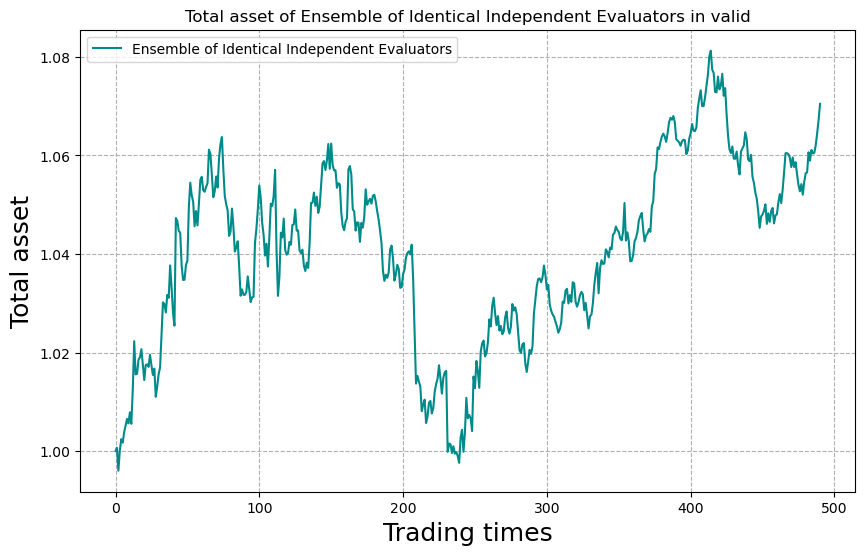

In [13]:
trainer.train_and_valid()

Test Best Episode
+--------------+-------------+------------+--------------+
| Total Return | Sharp Ratio | Volatility | Max Drawdown |
+--------------+-------------+------------+--------------+
|  2.577195%   |   2.855530  | 0.161494%  |  1.307260%   |
+--------------+-------------+------------+--------------+


array([ 0.00000000e+00,  4.32009343e-05, -2.68912621e-03, -7.89613766e-04,
       -1.16091444e-03, -1.26829910e-03,  2.89957456e-05, -1.38257483e-03,
        5.23361804e-03,  1.58371019e-03,  3.00236934e-03,  2.72030264e-04,
       -3.09704325e-04, -8.06957184e-04,  3.75606604e-03,  7.12949354e-04,
       -2.32412630e-03, -6.01841911e-04, -9.27792555e-05, -2.03593318e-03,
       -1.36402243e-03, -4.38123366e-04,  8.65561425e-04, -3.42744078e-03,
       -1.95131958e-04, -3.46514969e-04, -1.65135017e-03, -1.53222402e-03,
        5.53472206e-04,  3.20923050e-03,  1.22424807e-03, -1.15640083e-03,
       -1.25120746e-03,  3.23990863e-04,  3.30954822e-03,  3.04039324e-03,
       -1.24528927e-03,  1.73331836e-04,  3.71520351e-03,  1.15872091e-03,
        1.44807646e-03,  1.01640096e-03, -5.36120681e-04, -2.83600264e-04,
        8.77777002e-05,  2.15098689e-04,  3.25007774e-04, -1.30402488e-03,
        1.98022665e-03,  2.35012459e-03, -1.64066890e-04, -1.56751678e-03,
       -5.23966701e-04, -

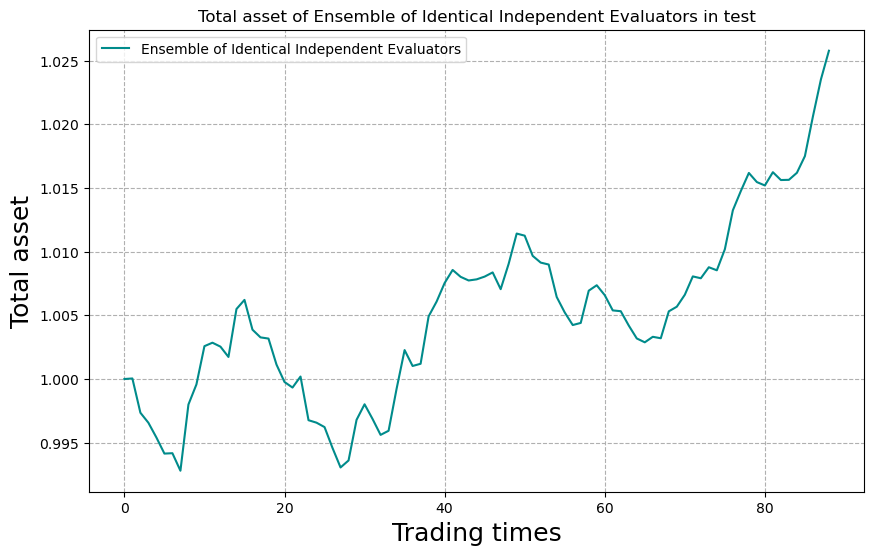

In [14]:
trainer.test()

In [15]:
trainer.test_environment.save_asset_memory()

,total assets
date,
2019-08-09,100000.000000
2019-08-23,100004.320093
2019-08-26,99735.395855
2019-08-27,99656.643413
2019-08-28,99540.950577
...,...
2019-12-24,101618.843942
2019-12-26,101749.775904
2019-12-27,102060.811428


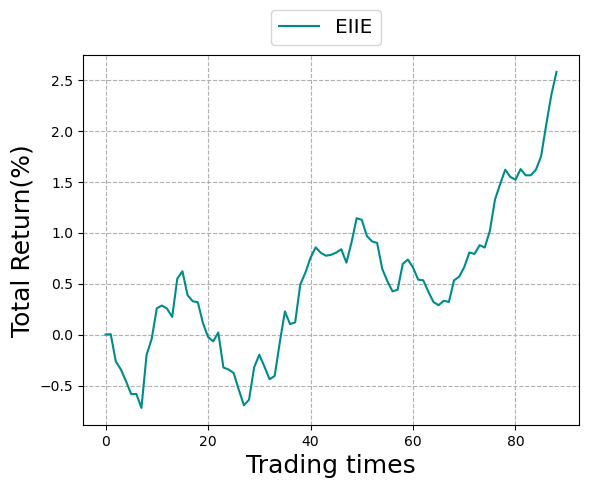

In [16]:
plot(trainer.test_environment.save_asset_memory(),alg="EIIE")

# IMIT

In [ ]:
%pip install torch==2.1.0

#### if you are prompted to restart the session do not panic. just restart the session and continue to run the cells below

In [ ]:
%cd trademaster-nyu

/content/trademaster-nyu


In [ ]:
import os
import sys
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")
ROOT = os.path.dirname(os.path.abspath("."))
sys.path.append(ROOT)
import torch
import argparse
import os.path as osp
from mmcv import Config
from trademaster.utils import replace_cfg_vals,create_radar_score_baseline, calculate_radar_score, plot_radar_chart
from trademaster.nets.builder import build_net
from trademaster.environments.builder import build_environment
from trademaster.datasets.builder import build_dataset
from trademaster.agents.builder import build_agent
from trademaster.optimizers.builder import build_optimizer
from trademaster.losses.builder import build_loss
from trademaster.trainers.builder import build_trainer
from trademaster.utils import set_seed
set_seed(2023)

In [ ]:
parser = argparse.ArgumentParser(description='Download Alpaca Datasets')
parser.add_argument("--config", default=osp.join(ROOT, "trademaster-nyu", "configs", "portfolio_management", "portfolio_management_dj30_investor_imitator_investor_imitator_adam_mse.py"),
                    help="download datasets config file path")
parser.add_argument("--task_name", type=str, default="train")
parser.add_argument("--test_dynamic", type=str, default="-1")
parser.add_argument("--verbose", type=int, default='1')
args, _= parser.parse_known_args()

In [ ]:
cfg = Config.fromfile(args.config)
task_name = args.task_name

cfg = replace_cfg_vals(cfg)
# update test style
cfg.data.update({'test_dynamic': args.test_dynamic})
if args.verbose == 1:
    print(cfg)

dataset = build_dataset(cfg)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_environment = build_environment(cfg, default_args=dict(dataset=dataset, task="train"))
valid_environment = build_environment(cfg, default_args=dict(dataset=dataset, task="valid"))
test_environment = build_environment(cfg, default_args=dict(dataset=dataset, task="test"))

if task_name.startswith("dynamics_test"):
    test_dynamic_environments = []
    for i, path in enumerate(dataset.test_dynamic_paths):
        test_dynamic_environments.append(build_environment(cfg, default_args=dict(dataset=dataset, task="test_dynamic",
                                                                                dynamics_test_path=path,
                                                                                task_index=i,work_dir=cfg.work_dir)))

action_dim = train_environment.action_dim
state_dim = train_environment.state_dim
input_dim = train_environment.observation_space.shape[1]

cfg.act.update(dict(input_dim=input_dim, output_dim=action_dim))

act = build_net(cfg.act)

work_dir = os.path.join(ROOT, cfg.trainer.work_dir)

if not os.path.exists(work_dir):
    os.makedirs(work_dir)
cfg.dump(osp.join(work_dir, osp.basename(args.config)))

act_optimizer = build_optimizer(cfg, default_args=dict(params=act.parameters()))

criterion = build_loss(cfg)

agent = build_agent(cfg, default_args=dict(action_dim=action_dim,
                                            state_dim=state_dim,
                                            act=act,
                                            act_optimizer=act_optimizer,
                                            criterion=criterion,
                                            device = device))

Config (path: /content/trademaster-nyu/configs/portfolio_management/portfolio_management_dj30_investor_imitator_investor_imitator_adam_mse.py): {'data': {'type': 'PortfolioManagementDataset', 'data_path': 'data/portfolio_management/dj30', 'train_path': 'data/portfolio_management/dj30/train.csv', 'valid_path': 'data/portfolio_management/dj30/valid.csv', 'test_path': 'data/portfolio_management/dj30/test.csv', 'tech_indicator_list': ['high', 'low', 'open', 'close', 'adjcp', 'zopen', 'zhigh', 'zlow', 'zadjcp', 'zclose', 'zd_5', 'zd_10', 'zd_15', 'zd_20', 'zd_25', 'zd_30'], 'length_day': 10, 'initial_amount': 100000, 'transaction_cost_pct': 0.0001, 'test_dynamic_path': 'data/portfolio_management/dj30/test_with_label.csv', 'test_dynamic': '-1'}, 'environment': {'type': 'PortfolioManagementInvestorImitatorEnvironment'}, 'agent': {'type': 'PortfolioManagementInvestorImitator', 'memory_capacity': 1000, 'gamma': 0.99, 'policy_update_frequency': 500}, 'trainer': {'type': 'PortfolioManagementInves

+--------------+-------------+------------+--------------+
| Total Return | Sharp Ratio | Volatility | Max Drawdown |
+--------------+-------------+------------+--------------+
| 275.791152%  |   0.816105  | 1.500608%  |  33.916393%  |
+--------------+-------------+------------+--------------+
Valid Episode: [1/10]
+--------------+-------------+------------+--------------+
| Total Return | Sharp Ratio | Volatility | Max Drawdown |
+--------------+-------------+------------+--------------+
| -39.657775%  |  -0.775518  | 3.101979%  |  55.080265%  |
+--------------+-------------+------------+--------------+
Train Episode: [2/10]
+--------------+-------------+------------+--------------+
| Total Return | Sharp Ratio | Volatility | Max Drawdown |
+--------------+-------------+------------+--------------+
| 125.368537%  |   0.543421  | 1.516364%  |  46.471903%  |
+--------------+-------------+------------+--------------+
Valid Episode: [2/10]
+--------------+-------------+------------+------

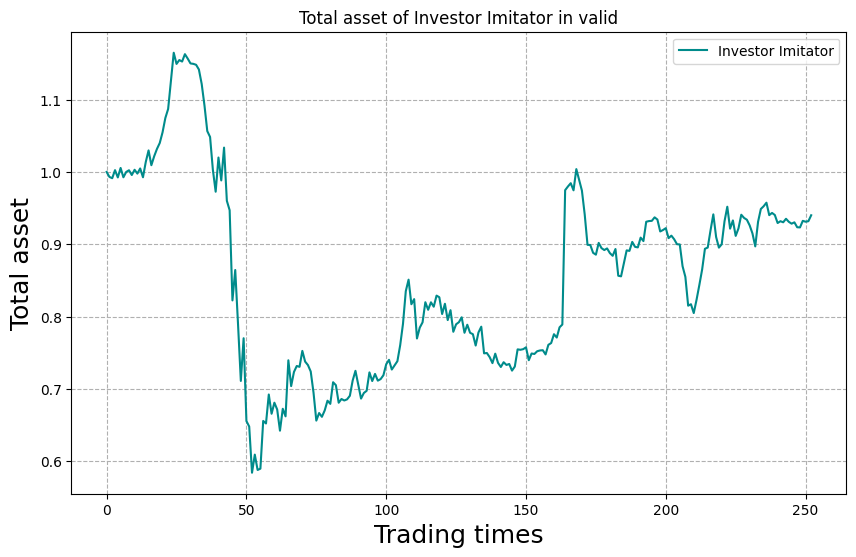

In [ ]:
trainer = build_trainer(cfg, default_args=dict(train_environment=train_environment,
                                                    valid_environment=valid_environment,
                                                    test_environment=test_environment,
                                                    agent=agent,
                                                    device=device,
                                                    ))
trainer.train_and_valid()

Test Best Episode
+--------------+-------------+------------+--------------+
| Total Return | Sharp Ratio | Volatility | Max Drawdown |
+--------------+-------------+------------+--------------+
|  30.261632%  |   1.646425  | 1.071237%  |  6.876512%   |
+--------------+-------------+------------+--------------+


array([ 0.00000000e+00,  7.43041247e-03, -4.31525968e-03,  1.58066440e-02,
        2.78828378e-03, -1.09695244e-02, -2.65354336e-03, -9.02152478e-04,
        1.32420354e-02, -6.77200532e-03,  7.93835425e-03,  1.73978256e-02,
       -3.36292005e-04,  1.79207635e-03, -3.42507255e-03, -2.97578257e-03,
       -1.55684013e-02,  3.63354548e-03, -2.06988222e-02,  3.32707562e-03,
        1.93445212e-02,  5.85687820e-03,  9.64822286e-03,  5.14070401e-04,
        1.03268688e-02, -3.20677480e-04, -1.33475518e-02,  7.83408662e-03,
       -4.44262939e-03,  1.68421022e-02,  1.37301717e-02, -8.17869896e-03,
       -4.02501141e-03, -1.30253461e-02,  2.73340521e-02,  2.22560146e-02,
       -4.38325961e-02, -1.47192583e-02,  2.51790111e-02, -7.76335868e-03,
       -1.68756729e-03, -1.30609626e-02,  1.90922788e-02,  8.65689925e-03,
       -1.37542255e-02,  4.36849936e-02,  2.04619697e-02,  4.65983891e-02,
       -1.32721419e-02,  8.84569768e-04,  1.47443923e-03, -2.38792734e-02,
        7.35021150e-03, -

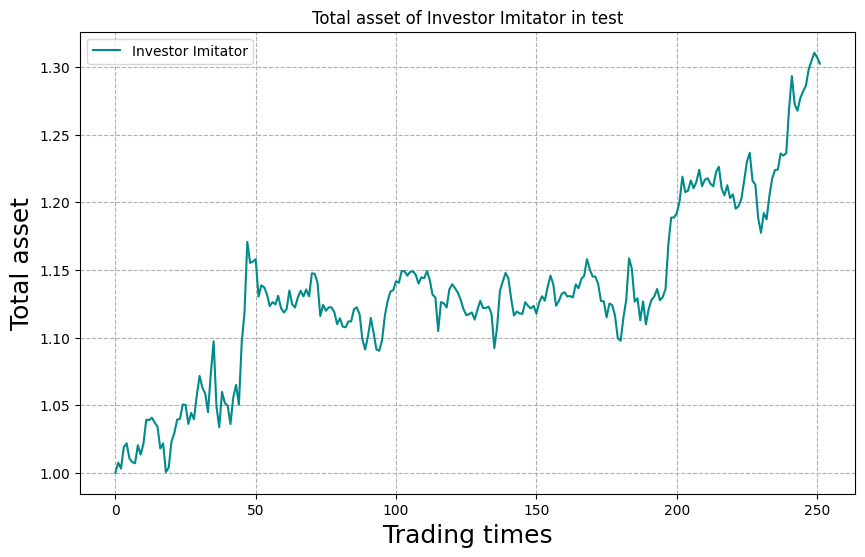

In [ ]:
trainer.test()

In [ ]:
trainer.test_environment.save_asset_memory()

,total assets
date,
2021-01-04,100000.000000
2021-01-05,100743.041247
2021-01-06,100308.308864
2021-01-07,101893.846596
2021-01-08,102177.955555
...,...
2021-12-27,129829.198443
2021-12-28,130474.141622
2021-12-29,131068.916770
